## Observations and Insights

## Dependencies and starter code

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata = "data/Mouse_metadata.csv"
study_results = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata)
study_results = pd.read_csv(study_results)

# Combine the data into a single dataset
study = pd.merge(study_results, mouse_metadata, on=['Mouse ID'], how='outer')

In [2]:
list(study['Drug Regimen'].unique())


['Capomulin',
 'Ketapril',
 'Naftisol',
 'Infubinol',
 'Stelasyn',
 'Ramicane',
 'Propriva',
 'Zoniferol',
 'Placebo',
 'Ceftamin']

## Summary statistics

In [3]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
tv_summary = pd.DataFrame()
tv_summary['Mean'] = study.groupby('Drug Regimen')['Tumor Volume (mm3)'].mean()
tv_summary['Median'] = study.groupby('Drug Regimen')['Tumor Volume (mm3)'].median()
tv_summary['Variance'] = study.groupby('Drug Regimen')['Tumor Volume (mm3)'].var()
tv_summary['STD'] = study.groupby('Drug Regimen')['Tumor Volume (mm3)'].std()
tv_summary['SEM'] = study.groupby('Drug Regimen')['Tumor Volume (mm3)'].sem()

(tv_summary.round(2)
           .style
           .set_caption('Summary of Tumor Volume by Regimen'))

,Mean,Median,Variance,STD,SEM
Drug Regimen,,,,,
Capomulin,40.680000,41.560000,24.950000,4.990000,0.330000
Ceftamin,52.590000,51.780000,39.290000,6.270000,0.470000
Infubinol,52.880000,51.820000,43.130000,6.570000,0.490000
Ketapril,55.240000,53.700000,68.550000,8.280000,0.600000
Naftisol,54.330000,52.510000,66.170000,8.130000,0.600000
Placebo,54.030000,52.290000,61.170000,7.820000,0.580000
Propriva,52.320000,50.850000,42.350000,6.510000,0.510000
Ramicane,40.220000,40.670000,23.490000,4.850000,0.320000
Stelasyn,54.230000,52.430000,59.450000,7.710000,0.570000


## Bar plots

In [7]:
# Generate a bar plot showing number of data points for each treatment regimen using pandas
points = study.groupby('Drug Regimen')['Mouse ID'].count()
points.head()

Drug Regimen
Capomulin    230
Ceftamin     178
Infubinol    178
Ketapril     188
Naftisol     186
Name: Mouse ID, dtype: int64

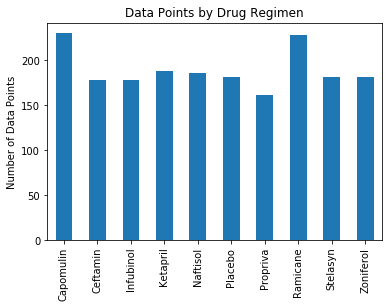

In [12]:
points.plot(kind='bar', title='Data Points by Drug Regimen')
plt.xlabel('')
plt.ylabel('Number of Data Points')
plt.show()

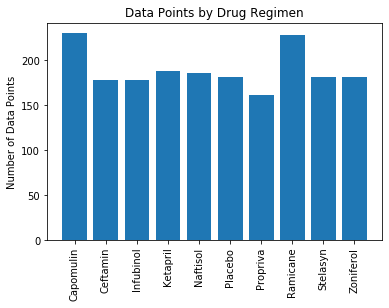

In [25]:
# Generate a bar plot showing number of data points for each treatment regimen using pyplot
plt.bar(points.index, points)
plt.xticks(points.index, rotation=90)
plt.title('Data Points by Drug Regimen')
plt.xlabel('')
plt.ylabel('Number of Data Points')
plt.show()

## Pie plots

In [ ]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

In [ ]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

## Quartiles, outliers and boxplots

In [ ]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. Calculate the IQR and quantitatively determine if there are any potential outliers. 

In [ ]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

## Line and scatter plots

In [ ]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin

In [ ]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen

In [ ]:
# Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen